Before feature engineering:
['Timestamp', 'IP_Address', 'Request_Type', 'Status_Code', 'Anomaly_Flag', 'User_Agent', 'Session_ID', 'Location']
Shape: (10000, 8)

After feature engineering:
['Timestamp', 'IP_Address', 'Request_Type', 'Status_Code', 'Anomaly_Flag', 'User_Agent', 'Session_ID', 'Location', 'hour', 'day_of_week', 'is_weekend', 'is_night', 'is_business_hours', 'requests_per_ip', 'failed_requests_per_ip', 'failure_rate', 'is_client_error', 'is_server_error', 'is_error', 'is_success', 'suspicious_user_agent', 'is_post', 'is_get', 'risk_score']
Shape: (10000, 24)

Sample with new features:
        IP_Address  requests_per_ip  failure_rate  risk_score  Anomaly_Flag
0   202.118.116.11                1           1.0         6.0             0
1     38.30.40.178                1           0.0         0.0             0
2     209.5.148.15                1           1.0         6.0             0
3    211.116.60.71                1           0.0         0.0             0
4   170.166.36.

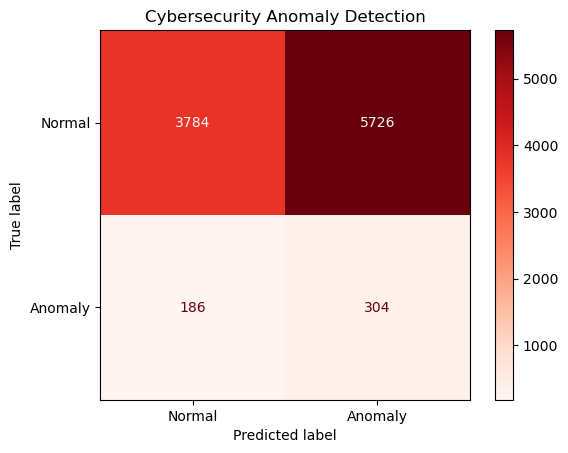

In [8]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def engineer_features(df):
    """
    Create advanced features for threat detection
    """
    df = df.copy()

    # Convert timestamp to datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    # TIME-BASED FEATURES
    df['hour'] = df['Timestamp'].dt.hour
    df['day_of_week'] = df['Timestamp'].dt.dayofweek
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['is_night'] = ((df['hour'] < 6) | (df['hour'] > 22)).astype(int)
    df['is_business_hours'] = ((df['hour'] >= 9) & (df['hour'] <= 17)).astype(int)

    # IP-BASED FEATURES
    # Count requests per IP
    ip_counts = df.groupby('IP_Address').size()
    df['requests_per_ip'] = df['IP_Address'].map(ip_counts)
    
    # Failed requests per IP
    failed = df[df['Status_Code'] >= 400].groupby('IP_Address').size()
    df['failed_requests_per_ip'] = df['IP_Address'].map(failed).fillna(0) # fill empty values with 0
    
    # Failure rate per IP
    df['failure_rate'] = df['failed_requests_per_ip'] / df['requests_per_ip']
    df['failure_rate'] = df['failure_rate'].fillna(0) # fill empty values with 0

    # STATUS CODE FEATURES (casting as int)
    df['is_client_error'] = ((df['Status_Code'] >= 400) & (df['Status_Code'] <500)).astype(int)
    df['is_server_error'] = (df['Status_Code'] >= 500).astype(int)
    df['is_error'] = (df['Status_Code'] >= 400).astype(int)
    df['is_success'] = (df['Status_Code'] < 400).astype(int)

    # RESPONSE TIME FEATURES
    # Z-score for response time (how anomalous)
    # mean_rt = df['response_time'].mean()
    # std_rt = df['response_time'].std()
    # df['response_time_zscore'] = (df['response_time'] - mean_rt) / std_rt
    # df['is_slow'] = (df['response_time_zscore'] > 2).astype(int)
    
    # USER AGENT FEATURES
    suspicious_agents = ['curl', 'python', 'wget', 'nmap', 'sqlmap', 'nikto', 'scrapy', 'Bot']
    df['suspicious_user_agent'] = df['User_Agent'].apply(lambda x: 1 if any(agent in str(x).lower() for agent in suspicious_agents) else 0)
    
    # HTTP METHOD FEATURES
    df['is_post'] = (df['Request_Type'] == 'POST').astype(int)
    df['is_get'] = (df['Request_Type'] == 'GET').astype(int)
    
    # COMBINED RISK SCORES
    df['risk_score'] = (df['suspicious_user_agent'] * 3 + df['failure_rate'] * 5 + df['is_error'] * 1)
    
    return df

if __name__ == "__main__":
    
    df = pd.read_csv("advanced_cybersecurity_data.csv")

    print("Before feature engineering:")
    print(df.columns.tolist())
    print(f"Shape: {df.shape}")

    # Engineer features
    df_enhanced = engineer_features(df)
    
    print("\nAfter feature engineering:")
    print(df_enhanced.columns.tolist())
    print(f"Shape: {df_enhanced.shape}")
    
    # Show sample
    print("\nSample with new features:")
    print(df_enhanced[['IP_Address', 'requests_per_ip', 'failure_rate', 'risk_score', 'Anomaly_Flag']].head(10))

    threshold = 2.0
    y_true = df_enhanced['Anomaly_Flag']
    y_pred = (df_enhanced['risk_score'] > threshold).astype(int)
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
    disp.plot(cmap='Reds')
    plt.title('Cybersecurity Anomaly Detection')
    plt.show()

    
